# Bi-BFS Verification

In [106]:
# pre-settings
import networkx as nx
import matplotlib.pyplot as plt
import random
import queue

## Eg. Draw Directed-Graph using `networkx`

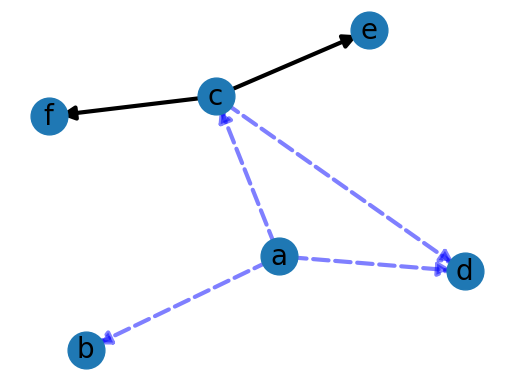

In [107]:
G1 = nx.DiGraph()

G1.add_edge('a', 'b', weight=0.6)
G1.add_edge('a', 'b', weight=0.2) # multiple adds for the same <src, dst> pair will be overlapped
# MultiGraph in networkx is multi-graph in mathematics
G1.add_edge('a', 'c', weight=0.2)
G1.add_edge('c', 'd', weight=0.1)
G1.add_edge('c', 'e', weight=0.7)
G1.add_edge('c', 'f', weight=0.9)
G1.add_edge('a', 'd', weight=0.3)

elarge = [(u, v) for (u, v, d) in G1.edges(data=True) if d['weight'] > 0.5]
esmall = [(u, v) for (u, v, d) in G1.edges(data=True) if d['weight'] <= 0.5]

pos = nx.spring_layout(G1)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G1, pos, node_size=700)

# edges
nx.draw_networkx_edges(G1, pos, edgelist=elarge,
                       width=3, arrowsize=20)
nx.draw_networkx_edges(G1, pos, edgelist=esmall,
                       width=3, alpha=0.5, edge_color='b', style='dashed', arrowsize=20)

# labels
nx.draw_networkx_labels(G1, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

In [108]:
for path in nx.all_simple_paths(G1, source='a', target='d'):
    print(path)

['a', 'c', 'd']
['a', 'd']


In [109]:
list(G1.neighbors('e'))

[]

## Implement verification algorithm here
### Module1: Create graph
*Create testcases that may cover different kinds of conner cases*

In [110]:
case_id2_path = {0: "./testcase/dir-graph_001.dot",
                 1: "./testcase/dir-graph_002.dot",
                 2: "./testcase/dir-graph_003.dot"}

In [111]:
case_id2_src_dst = {0: ['a', 'b', 'c'],
                    1: ['a', 'f', 'e'],
                    2: ['d', 'e', 'h']}

In [112]:
def create_case(case_id, rand_src_dst = False):
    G = nx.drawing.nx_pydot.read_dot(case_id2_path[case_id])
    if rand_src_dst:
        G_node_list = list(G.nodes())
        random_items = random.sample(G_node_list, 3)
        return (G, random_items[:2], random_items[-1])
    else:
        return (G, case_id2_src_dst[case_id][:2], case_id2_src_dst[case_id][-1])

### Module2: Traverse the graph and create sub-graph using Bi-BFS

In [113]:
# do bfs multiple times to find reachable point to src and from dst
def bi_bfs(G, src_nodes, dst_node):
    srcs_reachable_set = set()
    for src in src_nodes:
        src_rechable_set = bfs(G, src)
        srcs_reachable_set = srcs_reachable_set.union(src_rechable_set)
    dst_reached_set = bfs(G, dst_node, True)
    sub_graph_nodes = dst_reached_set.intersection(srcs_reachable_set)
    sub_graph = G.subgraph(sub_graph_nodes)
    return sub_graph

In [114]:
# using bfs for reachable searching
def bfs(G, node, reverse_dir = False):
    waiting_queue = queue.Queue()
    waiting_queue.put(node)
    reachable_nodes = set({node, })
    while not waiting_queue.empty():
        present_node = waiting_queue.get()
        if reverse_dir:
            neighbour_list = G.predecessors(present_node)
        else:
            neighbour_list = G.neighbors(present_node)
        for n_v in neighbour_list:
            if n_v not in reachable_nodes:
                reachable_nodes.add(n_v)
                waiting_queue.put(n_v)
    return reachable_nodes

In [122]:
def bi_bfs2(G, src_nodes, dst_node):
    # init bfs from srcs
    srcs_reachable_set = set(src_nodes)
    srcs_waiting_queue_now= queue.Queue()
    for src_n in src_nodes:
        srcs_waiting_queue_now.put(src_n)
    srcs_waiting_queue_next = queue.Queue()

    # init bfs from dst
    dst_reached_set = set({dst_node, })
    dst_waiting_queue_now = queue.Queue()
    dst_waiting_queue_now.put(dst_node)
    dst_waiting_queue_next = queue.Queue()

    # total layer counter
    bfs_layer = 2
    # G's |V| value
    G_node_num = len(list(G.nodes))

    while (not srcs_waiting_queue_now.empty()) or (not dst_waiting_queue_now.empty()):
        # move to the next layer based on a heuristic strategy
        srcs_queue_size = len(list(srcs_waiting_queue_now.queue))
        dst_queue_size = len(list(dst_waiting_queue_now.queue))
        if srcs_queue_size != 0 and dst_queue_size != 0:
            if srcs_queue_size > dst_queue_size:
                # then step a layer from dst side
                while (not dst_waiting_queue_now.empty()):
                    present_node = dst_waiting_queue_now.get()
                    neighbour_list = G.predecessors(present_node)
                    for n_v in neighbour_list:
                        if bfs_layer <= G_node_num and (n_v not in dst_reached_set):
                            dst_reached_set.add(n_v)
                            dst_waiting_queue_next.put(n_v)
                        elif bfs_layer > G_node_num and (n_v not in dst_reached_set) and (n_v in srcs_reachable_set):
                            dst_reached_set.add(n_v)
                            dst_waiting_queue_next.put(n_v)
                dst_waiting_queue_now = dst_waiting_queue_next
                dst_waiting_queue_next = queue.Queue()
            else:
                # then step a layer from srcs side
                while (not srcs_waiting_queue_now.empty()):
                    present_node = srcs_waiting_queue_now.get()
                    neighbour_list = G.neighbors(present_node)
                    for n_v in neighbour_list:
                        if bfs_layer <= G_node_num and (n_v not in srcs_reachable_set):
                            srcs_reachable_set.add(n_v)
                            srcs_waiting_queue_next.put(n_v)
                        elif bfs_layer > G_node_num and (n_v not in srcs_reachable_set) and (n_v in dst_reached_set):
                            srcs_reachable_set.add(n_v)
                            srcs_waiting_queue_next.put(n_v)
                srcs_waiting_queue_now =srcs_waiting_queue_next
                srcs_waiting_queue_next = queue.Queue()
        elif srcs_queue_size == 0:
            # then we can only step a layer from the dst side
            while (not dst_waiting_queue_now.empty()):
                present_node = dst_waiting_queue_now.get()
                neighbour_list = G.predecessors(present_node)
                for n_v in neighbour_list:
                    if (n_v not in dst_reached_set) and (n_v in srcs_reachable_set):
                        dst_reached_set.add(n_v)
                        dst_waiting_queue_next.put(n_v)
            dst_waiting_queue_now = dst_waiting_queue_next
            dst_waiting_queue_next = queue.Queue()
        else:
            # then we can only step a layer from the src side
            while (not srcs_waiting_queue_now.empty()):
                present_node = srcs_waiting_queue_now.get()
                neighbour_list = G.neighbors(present_node)
                for n_v in neighbour_list:
                    if (n_v not in srcs_reachable_set) and (n_v in dst_reached_set):
                        srcs_reachable_set.add(n_v)
                        srcs_waiting_queue_next.put(n_v)
            srcs_waiting_queue_now =srcs_waiting_queue_next
            srcs_waiting_queue_next = queue.Queue()

        bfs_layer += 1
        print("bfs_layer is {}".format(bfs_layer))
        print("srcs_reachable is {}".format(str(srcs_reachable_set)))
        print("dst_reached is {}".format(str(dst_reached_set)))
        print("srcs_queue: {}".format(str(list(srcs_waiting_queue_now.queue))))
        print("dst_queue: {}".format(str(list(dst_waiting_queue_now.queue))))

    # bfs_finished, do intersection
    sub_graph_nodes = dst_reached_set.intersection(srcs_reachable_set)
    sub_graph = G.subgraph(sub_graph_nodes)
    return sub_graph

In [116]:
testcase1 = create_case(2)

display graph before slicing

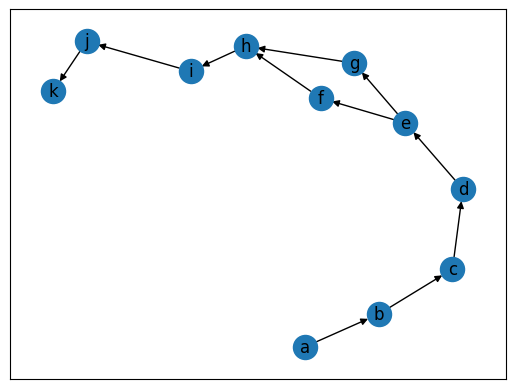

In [117]:
pos = nx.spring_layout(testcase1[0])  # positions for all nodes
nx.draw_networkx(testcase1[0], pos)

In [118]:
# do slicing, res is the sliced graph
res = bi_bfs(testcase1[0], testcase1[1], testcase1[2])

display graph after slicing

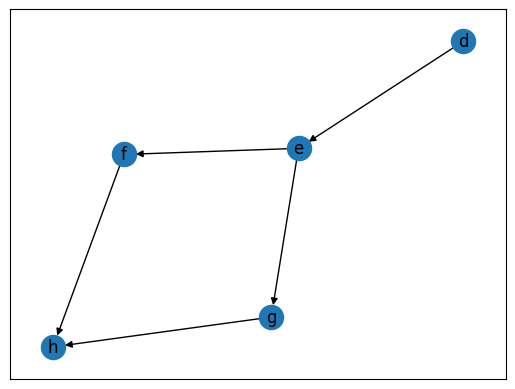

In [119]:
pos_sub = nx.spring_layout(res)
nx.draw_networkx(res,pos_sub)
plt.show()

In [123]:
res2 = bi_bfs2(testcase1[0], testcase1[1], testcase1[2])

bfs_layer is 3
srcs_reachable is {'e', 'd'}
dst_reached is {'g', 'f', 'h'}
srcs_queue: ['d', 'e']
dst_queue: ['f', 'g']
bfs_layer is 4
srcs_reachable is {'e', 'd', 'f', 'g'}
dst_reached is {'g', 'f', 'h'}
srcs_queue: ['f', 'g']
dst_queue: ['f', 'g']
bfs_layer is 5
srcs_reachable is {'g', 'h', 'f', 'd', 'e'}
dst_reached is {'g', 'f', 'h'}
srcs_queue: ['h']
dst_queue: ['f', 'g']
bfs_layer is 6
srcs_reachable is {'g', 'h', 'f', 'i', 'd', 'e'}
dst_reached is {'g', 'f', 'h'}
srcs_queue: ['i']
dst_queue: ['f', 'g']
bfs_layer is 7
srcs_reachable is {'g', 'h', 'f', 'i', 'd', 'e', 'j'}
dst_reached is {'g', 'f', 'h'}
srcs_queue: ['j']
dst_queue: ['f', 'g']
bfs_layer is 8
srcs_reachable is {'k', 'g', 'h', 'f', 'i', 'd', 'e', 'j'}
dst_reached is {'g', 'f', 'h'}
srcs_queue: ['k']
dst_queue: ['f', 'g']
bfs_layer is 9
srcs_reachable is {'k', 'g', 'h', 'f', 'i', 'd', 'e', 'j'}
dst_reached is {'g', 'f', 'h'}
srcs_queue: []
dst_queue: ['f', 'g']
bfs_layer is 10
srcs_reachable is {'k', 'g', 'h', 'f', 'i'

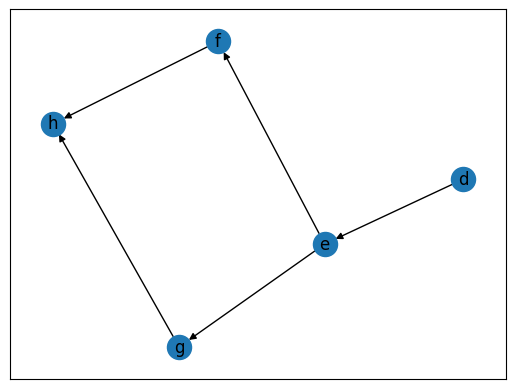

In [121]:
pos_sub2 = nx.spring_layout(res2)
nx.draw_networkx(res2,pos_sub2)
plt.show()

### Module3: Output both graphs